# Setup

In [1]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 211 kB 26.7 MB/s 
     |████████████████████████████████| 182 kB 66.9 MB/s 
     |████████████████████████████████| 7.6 MB 31.8 MB/s 
     |████████████████████████████████| 81 kB 4.2 MB/s 
     |████████████████████████████████| 7.4 MB 11.6 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=67c3ac56d0dc2fd0331e8d09b1f258e0c6a3bddbeeea48cd451ae534ee6fc91c
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=8d0c0d41c34df23a8de78d27d5368831a8ff3514f2cdf9b84807cdfcf39205b3
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c23d

In [2]:
# ! python -m spacy download en_core_web_sm

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# Preprocessing

In [7]:
TARGET = 'label'
TEXT = 'text'
STOPWORDS = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [8]:
# Constants that will disappear when transitioning to functions:
# Cell 1
html_folder = HTML_FOLDER
# Cell 2
csv_path = 'url_classification_temporary481.csv'
usecols = ['File Name', 'Label']

In [9]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [10]:
# Important cell # 2

df = pd.read_csv(csv_path, usecols=usecols)
df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-']
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

Original shape: (480, 2)
Final shape: (410, 2)


In [11]:
# Important cell # 3
df[TARGET].value_counts(normalize=False)

Home Page        143
Blog              79
MISC              74
Product Page      41
Article           32
Event             15
White Paper       12
Education          6
?                  3
Press Release      2
Video Content      1
About Page         1
Publication        1
Name: label, dtype: int64

In [12]:
# Important cell # 4
filenames = df['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [13]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [47]:
# Important cell # 6
y = df[TARGET].tolist()

In [48]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [49]:
len(y), len(summaries)

(410, 410)

In [50]:
# Cell 8
minimum_words = 30 
maximum_classes = 4

# Important cell # 8
df_text = pd.DataFrame({TEXT: summaries, TARGET: y})

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

if maximum_classes:
  relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
  df_text = df_text[df_text[TARGET].isin(relevant_labels)]
  
df_text.reset_index(drop=True, inplace=True)

In [51]:
df_text

,text,label
0,Write For Us. Want to Write for Us? Digital L...,MISC
1,"Write for Us. Yes, you. We’re always looking f...",MISC
2,FAQs for some new features available in the Be...,Blog
3,The Web Credibility Project. Our research in W...,Home Page
4,Model DJs for Retail. DJPeoples is the nation’...,MISC
...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC


In [72]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 8
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 259791
Amount of unique words before cleaning text: 29203

Amount of words after cleaning text: 155600
Amount of unique words before cleaning text: 17981


In [67]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 259791
Amount of unique words before lemmatizing text: 29203

Amount of words after lemmatizing text: 313428
Amount of unique words before lemmatizing text: 13759


In [73]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 313428
Amount of unique words before cleaning lemmatized text: 13759

Amount of words after cleaning lemmatized text: 145758
Amount of unique words before cleaning lemmatized text: 13021


In [69]:
df_text.loc[0, TEXT]

'Write For Us. Want to Write for Us?  Digital Lamp, is one of the fastest-growing tech blog. We allow you an endless opportunity for new authors, technical content writers, freelance content writing professionals, and guest writers to technology + “write for us” + guest post (Contribute or Submit Guest Post Article) about the topics related to Technology, Business, Internet, Gadgets, Digital Marketing, Security, SEO, Tech Blog, etc.  Technology is the way progressive for online businesses. Why not share your expertise by guest blogging on technology blogs to highlight awareness of this emerging trend.  You will obtain the benefits of being a guest blogger by establishing yourself as an authority in the industry. On top of that, you will build social proof, create a robust online presence, develop new relationships with bloggers and readers and rank better in the search engines.  All you need to do is meet the criteria set out by the technology blogs below and submit your best work as a

In [70]:
df_text.loc[0, 'lemmatized_text']

'write for we . want to write for we ?   Digital Lamp , be one of the fast - grow tech blog . we allow you an endless opportunity for new author , technical content writer , freelance content write professional , and guest writer to technology + " write for we " + guest post ( contribute or submit Guest Post Article ) about the topic relate to Technology , Business , Internet , Gadgets , Digital Marketing , security , seo , Tech Blog , etc .   Technology be the way progressive for online business . why not share your expertise by guest blogging on technology blog to highlight awareness of this emerge trend .   you will obtain the benefit of be a guest blogger by establish yourself as an authority in the industry . on top of that , you will build social proof , create a robust online presence , develop new relationship with blogger and reader and rank well in the search engine .   all you need to do be meet the criterion set out by the technology blog below and submit your good work as 

In [74]:
df_text.loc[0, 'lemmatized_cleaned_text']

'write want write Digital Lamp one fast grow tech blog allow endless opportunity new author technical content writer freelance content write professional guest writer technology + write + guest post contribute submit Guest Post Article topic relate Technology Business Internet Gadgets Digital Marketing security seo Tech Blog etc Technology way progressive online business share expertise guest blogging technology blog highlight awareness emerge trend obtain benefit guest blogger establish authority industry top build social proof create robust online presence develop new relationship blogger reader rank well search engine need meet criterion set technology blog submit good work guest blogger guideline Write Technology Blog Content must high quality informative 100 Copyscape pass article article must english language content length minimum 1000 + word Content must well format sub heading short paragraph 2 3 line article publish Digital Lamp request removal entertain remove link request l

In [23]:
# df_text['lemmatized_text'].tolist()[10:30]

In [75]:
# Important cell # 9
column_used = 'lemmatized_cleaned_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

In [76]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.3833


In [77]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 1197),
 ('content', 1154),
 ('I', 1043),
 ('post', 999),
 ('get', 840),
 ('make', 827),
 ('write', 762),
 ('search', 756),
 ('email', 740),
 ('page', 711)]

In [78]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [79]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((238, 183386), (60, 183386))

In [28]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

# Modeling

In [29]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf

In [30]:
def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred

In [31]:
def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

In [32]:
def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')

In [33]:
def print_confusion_matrix(y_test, y_pred, with_report=False):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {get_accuracy(y_test, y_pred):.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))

In [34]:
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy

In [83]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    # ('KNN 7', KNeighborsClassifier(n_neighbors=7)),
    # ('KNN 12', KNeighborsClassifier(n_neighbors=12)),
    # ('KNN 20', KNeighborsClassifier(n_neighbors=20)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.816667
RandomForest        0.700000
KNN 5               0.500000
SVM C1              0.700000
MultinomialNB       0.566667
Best classifier: LogisticRegression, test accuracy: 0.817


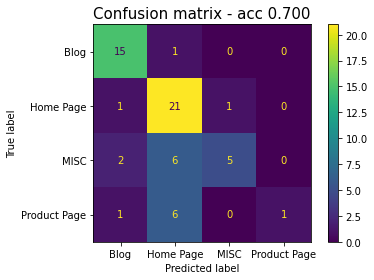


              precision    recall  f1-score   support

        Blog       0.79      0.94      0.86        16
   Home Page       0.62      0.91      0.74        23
        MISC       0.83      0.38      0.53        13
Product Page       1.00      0.12      0.22         8

    accuracy                           0.70        60
   macro avg       0.81      0.59      0.59        60
weighted avg       0.76      0.70      0.65        60



In [81]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

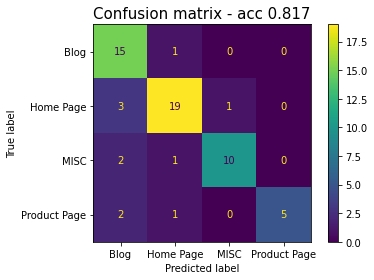


              precision    recall  f1-score   support

        Blog       0.68      0.94      0.79        16
   Home Page       0.86      0.83      0.84        23
        MISC       0.91      0.77      0.83        13
Product Page       1.00      0.62      0.77         8

    accuracy                           0.82        60
   macro avg       0.86      0.79      0.81        60
weighted avg       0.84      0.82      0.82        60



In [84]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [45]:
def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')

print_important_features(clf, features=5) # with 'lemmatized_text' column

Class "Blog" - 5 most important features: ['guest' 'guest post' 'product' 'our' 'ecommerce']
Class "Home Page" - 5 most important features: ['to' 'the' 'be' 'your' 'you']
Class "MISC" - 5 most important features: ['search' 'seo' 'of' 'that' 'essay']
Class "Product Page" - 5 most important features: ['the' 'post' 'be' 'guest' 'to']


In [85]:
print_important_features(clf, features=5) # with 'lemmatized_cleaned_text' column

Class "Blog" - 5 most important features: ['guest' 'guest post' 'please' 'digital' 'shipping']
Class "Home Page" - 5 most important features: ['post' 'write' 'content' 'customer' 'guest']
Class "MISC" - 5 most important features: ['search' 'seo' 'essay' 'stock' 'google']
Class "Product Page" - 5 most important features: ['post' 'guest' 'article' 'blog' 'guest post']


In [38]:
def create_misclassified_df(X_test, y_test, y_pred):
  df = X_test.copy()[y_pred != y_test]
  df['y_true'] = y_test[y_pred != y_test]
  df['y_pred'] = y_pred[y_pred != y_test]
  return df

misclassified_df = create_misclassified_df(X_test, y_test, y_pred) # with 'lemmatized_text' column
misclassified_df

,lemmatized_text,y_true,y_pred
234,MIPA - DKIM . Home Deployment ietf WG FAQ m...,MISC,Blog
203,"Cryptonizor – know how to Store . Aug 1 , 2022...",Home Page,Blog
235,dmarc.org – Domain Message Authentication Repo...,Home Page,Blog
295,Digital Marketing & Entrepreneurship Blog . wh...,MISC,Home Page
52,"search listening tool for market , customer & ...",Home Page,Blog
26,AI Chatbot Software for Automated Customer Ser...,Product Page,Home Page
173,Content Analytics and Insights for Digital Pub...,Home Page,Blog
212,powerful api Stack for Data - drive seo Tools ...,Blog,Home Page
42,seo Toolbar by Ahrefs . what be Ahrefs seo Too...,Product Page,Home Page
263,Fearlessflyer.com . interested in writing for ...,Home Page,MISC


In [86]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred) # with 'lemmatized_cleaned_text' column
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
234,MIPA DKIM Home Deployment ietf WG FAQ mipa dki...,MISC,Blog
184,Content Strategy Enterprise Marketers Content ...,Home Page,Blog
295,Digital Marketing Entrepreneurship Blog would ...,MISC,Home Page
52,search listening tool market customer content ...,Home Page,Blog
26,AI Chatbot Software Automated Customer Service...,Product Page,Home Page
173,Content Analytics Insights Digital Publishing ...,Home Page,Blog
212,powerful api Stack Data drive seo Tools datafo...,Blog,Home Page
42,seo Toolbar Ahrefs Ahrefs seo Toolbar Ahrefs s...,Product Page,Blog
263,Fearlessflyercom interested writing fuel artic...,Home Page,MISC
57,check Visibility Index check SISTRIX Visibilit...,Product Page,Blog
